Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Tune XGBoost with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of XGBoost with a regression example.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Regression Example
### Load data and preprocess

Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id = 537, data_dir = './')

load dataset from ./openml_ds537.pkl
Dataset name: houses
X_train.shape: (15480, 8), y_train.shape: (15480,);
X_test.shape: (5160, 8), y_test.shape: (5160,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'r2', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'], # list of ML learners; we tune xgboost in this example
    "task": 'regression', # task type    
    "log_file_name": 'houses_experiment.log', # flaml log file
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 02-23 14:54:34] {853} INFO - Evaluation method: cv
INFO - Evaluation method: cv
[flaml.automl: 02-23 14:54:34] {577} INFO - Using RepeatedKFold
INFO - Using RepeatedKFold
[flaml.automl: 02-23 14:54:34] {874} INFO - Minimizing error metric: 1-r2
INFO - Minimizing error metric: 1-r2
[flaml.automl: 02-23 14:54:34] {894} INFO - List of ML learners in AutoML Run: ['xgboost']
INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 02-23 14:54:34] {953} INFO - iteration 0  current learner xgboost
INFO - iteration 0  current learner xgboost
[flaml.automl: 02-23 14:54:35] {1107} INFO -  at 1.3s,	best xgboost's error=2.1267,	best xgboost's error=2.1267
INFO -  at 1.3s,	best xgboost's error=2.1267,	best xgboost's error=2.1267
[flaml.automl: 02-23 14:54:35] {953} INFO - iteration 1  current learner xgboost
INFO - iteration 1  current learner xgboost
[flaml.automl: 02-23 14:54:35] {1107} INFO -  at 1.4s,	best xgboost's error=2.1267,	best xgboost's error=2.1267
INFO -  at

### Best model and metric

In [5]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 317.0, 'max_leaves': 216.0, 'min_child_weight': 20.0, 'learning_rate': 0.03224270129795047, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9439217658719203, 'reg_alpha': 1.0302456093366526e-07, 'reg_lambda': 1.0}
Best r2 on validation data: 0.8399
Training duration of best run: 23.02 s


In [6]:
automl.model

In [7]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [8]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels [144760.3  259431.67 158536.47 ... 172862.03 235544.52 272218.38]
True labels [136900. 241300. 200700. ... 160900. 227300. 265600.]


In [9]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

r2 = 0.8381301879550651
mse = 2139677169.3730364
mae = 30461.545708424175


In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'xgboost', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}, 'Best Learner': 'xgboost', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}}
{'Current Learner': 'xgboost', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.46335414315327306, 'subsample': 0.9339389930838808, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9904286645657556, 'reg_alpha': 2.841147337412889e-10, 'reg_lambda': 0.12000833497054482}, 'Best Learner': 'xgboost', 'Best Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.

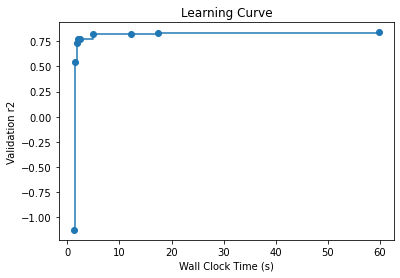

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.scatter(time_history, 1-np.array(valid_loss_history))
plt.step(time_history, 1-np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with untuned XGBoost

### FLAML's accuracy

In [12]:
print('flaml (60s) r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

flaml (60s) r2 = 0.8381301879550651


### Default XGBoost

In [13]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [14]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_pred = xgb.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default xgboost r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

default xgboost r2 = 0.8265451174596482
